# Assignment 3: object detection

In this assignment, we will localize chicory in an image and obtain the optimal cutting line of the chicory. We will use the YOLOv8 keypoint detector to do this. The dataset of images containing chicory contains labels with a bounding box and two points representing the cutting line. First, we will import all necessary modules that we need to get the job done. The next parts of the code are organized in: data analysis, data preprocessing, model training, and model validation. 

In [2]:
# Imports
import os
import requests
from PIL import Image
from io import BytesIO
! pip install ultralytics > /dev/null
import ultralytics
from ultralytics import YOLO
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
%load_ext tensorboard

## Data analyis

In the first step, we will download the data. The data folder contains a folder with images and a folder with labels in the YOLO format. This format has a .txt file for every image with one line for each annotation. Each line contains the image class, the normalized bounding box coordinates [x_center, y_center, width, height], and the coordinates of the two points [x1, y1, x2, y2]. We also use a .json file with all labels in COCO format for visualization of the labels.  

In [2]:
# Download data
if not os.path.exists('data/chicory_data'):
    !wget -q --no-check-certificate -O dataset.zip "https://kuleuven-my.sharepoint.com/:u:/g/personal/matthias_deryck_kuleuven_be/EUD1b3ZjnixMnG9XLTAhBSABPVeLHHEuLhq6zbygg0nb_g?e=n5lOdk&download=1"
    !unzip -q dataset.zip -d data
    !rm dataset.zip

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


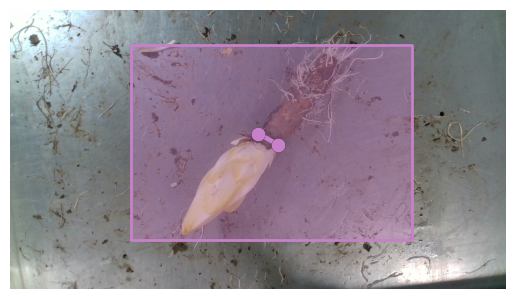

In [3]:
# Create a COCO object from the COCO annotations file
coco = COCO('./data/chicory_data/witloof_dataset_coco.json')

# Get the annotations for the first image
annotations = coco.loadAnns(coco.getAnnIds(imgIds=1))

# Get the image info
img_info = coco.loadImgs(1)[0]
height, width = img_info['height'], img_info['width']
file_name = img_info['file_name']

# Load the image
response = requests.get(file_name)
image = Image.open(BytesIO(response.content))

# Pot annotations
plt.imshow(image); plt.axis('off')
coco.showAnns(annotations, draw_bbox=True)
plt.show()

## Data preprocessing

For a proper pipeline, we will split our total dataset into a training, validation, and testset. De model gets trained on images from the training set. After each batch, the model is validated on the validation set. After training, we can evaluate the final model on the testset. 

In [4]:
# Split data in 80% training, 10% validation, and 10% test sets
ultralytics.data.utils.autosplit(path='./data/chicory_data/images', weights=(0.8, 0.1, 0.1), annotated_only=False)

Autosplitting images from data\chicory_data\images


100%|██████████| 216/216 [00:00<00:00, 2572.51it/s]


## Model training

In the next step, we will train our model. The model that we use is a pretrained YOLOv8n-pose model that was trained on the COCO dataset. We use the Ultralytics API for the training and validation phase. More info on: https://docs.ultralytics.com/tasks/pose/. All model parameters are logged during training, all parameters can be visualized using Tensorboard which will be activated below. 

In [ ]:
# Run tensorboard
%tensorboard --logdir runs/pose/train

In [5]:
# Load a YOLOv8 nano model for pose estimation
model = YOLO('yolov8n-pose.yaml').load('yolov8n-pose.pt')

# Training params
epochs = 20 # All data is sent 'epoch' times through the network
image_size = 640 # All images are resized to this size before entering the network

# Train the model on the data
results = model.train(data='./data/chicory_data/witloof_dataset.yaml', epochs=epochs, imgsz=image_size)

Transferred 397/397 items from pretrained weights
Ultralytics YOLOv8.1.14 🚀 Python-3.10.11 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A500 Laptop GPU, 4096MiB)
engine\trainer: task=pose, mode=train, model=yolov8n-pose.yaml, data=./data/chicory_data/witloof_dataset.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, sa

100%|██████████| 6.23M/6.23M [00:00<00:00, 7.90MB/s]


AMP: checks passed ✅


train: Scanning C:\Users\matth\OneDrive - KU Leuven\Python_Projects\mv4qc_workshop\data\chicory_data\labels... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<00:00, 1217.71it/s]

train: New cache created: C:\Users\matth\OneDrive - KU Leuven\Python_Projects\mv4qc_workshop\data\chicory_data\labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\matth\OneDrive - KU Leuven\Python_Projects\mv4qc_workshop\data\chicory_data\labels... 27 images, 0 backgrounds, 0 corrupt: 100%|██████████| 27/27 [00:00<00:00, 793.15it/s]

val: New cache created: C:\Users\matth\OneDrive - KU Leuven\Python_Projects\mv4qc_workshop\data\chicory_data\labels.cache


Plotting labels to runs\pose\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\pose\train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.27G      1.904     0.7125          0      3.567      2.002         12        640: 100%|██████████| 11/11 [00:05<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]

                   all         27         27      0.271      0.481      0.353      0.183       0.52      0.667      0.596      0.483



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.15G       1.21     0.4576          0      1.846      1.338         16        640: 100%|██████████| 11/11 [00:02<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         27         27      0.892      0.921      0.958       0.65      0.892      0.921      0.958      0.876



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.09G      1.093     0.2779          0      1.426      1.208         39        640:  45%|████▌     | 5/11 [00:01<00:01,  3.74it/s]


KeyboardInterrupt: 

As training can take some time, we only trained for 10 epochs. But for validation, we have trained a network for 100 epochs earlier and will load this here for further analysis. 

In [3]:
# Load the trained model
model = YOLO('./runs/pose/train/weights/best.pt')

After loading the model, we will validate it on new data. 

In [4]:
# Validate the model
metrics = model.val(split='test')

Ultralytics YOLOv8.1.14 🚀 Python-3.10.11 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A500 Laptop GPU, 4096MiB)
YOLOv8n-pose summary (fused): 187 layers, 3077762 parameters, 0 gradients, 8.3 GFLOPs


FileNotFoundError: './data/data_wout/witloof_dataset.yaml' does not exist

In [5]:
# Predict with the model
results = model('./data/chicory_data/autosplit_test.txt', stream=True)  # predict on an image

# Plot results
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    plt.imshow(im)
    plt.show()


image 1/216 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\mv4qc_workshop\data\chicory_data\images\sample_0.jpg: 384x640 1 chicory, 99.2ms
image 2/216 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\mv4qc_workshop\data\chicory_data\images\sample_1.jpg: 384x640 1 chicory, 102.3ms
image 3/216 c:\Users\matth\OneDrive - KU Leuven\Python_Projects\mv4qc_workshop\data\chicory_data\images\sample_10.jpg: 384x640 1 chicory, 107.7ms


KeyboardInterrupt: 